In [1]:
import os
import copy
from collections import OrderedDict
from collections import defaultdict
import pickle

import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(42)

In [2]:
class DataTable: pass
all_table = joblib.load("prepared_data/all_data_dropped_na.jbl")

if not os.path.exists("images/reliability"):
    os.makedirs("images/reliability")

In [3]:
matrix = all_table.matrix

overpaid_contracts = []
underpaid_contracts = []

for key, df in matrix.groupby('CONTRACT_ID'):
    df_copy = copy.deepcopy(df)[['CONTRACT_ID', 'CUMSUM_REPAYMENT_ACTUAL', 'CUMSUM_REPAYMENT_SCHEDULED', 'REPAYMENT_ACTUAL']]
    df_copy['CUMSUM_REPAYMENT_ACTUAL'] += df_copy['REPAYMENT_ACTUAL']
    df_copy = df_copy.drop('REPAYMENT_ACTUAL', axis=1)
    underpay = False
    for index, row in df_copy.iterrows():
        if not np.isnan(row['CUMSUM_REPAYMENT_ACTUAL']) and row['CUMSUM_REPAYMENT_ACTUAL'] < row['CUMSUM_REPAYMENT_SCHEDULED']:
            underpay = True
    if underpay:
        underpaid_contracts.append(key)
    else:
        overpaid_contracts.append(key)

print("len underpaid = ", len(underpaid_contracts))
print("len overpaid = ", len(overpaid_contracts))

len underpaid =  444
len overpaid =  3348


In [4]:
data_static = pd.read_csv('raw_data/Static.csv', sep=';').drop('CLIENT_ID', axis=1)
data_static['UNDERPAID'] = 0
data_static['UNDERPAID'][data_static['CONTRACT_ID'].isin(underpaid_contracts)] = 1
data_static['GENDER'] = 1 * (data_static['GENDER'] == 'M')

<ipython-input-4-14141a9770c0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_static['UNDERPAID'][data_static['CONTRACT_ID'].isin(underpaid_contracts)] = 1


# Metrics

In [5]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score

from sklearn.metrics import classification_report

def compute_metrics(y_pred, y_true):
    scores = classification_report(y_true, y_pred, output_dict=True)
    return scores
    

In [6]:
class TableBuilder:
    def __init__(self):
        self.column2list = defaultdict(list)
        
    def commit(self, algo, report):
        self.column2list['algorithm'].append(algo)
        self.column2list['accuracy'].append(report['accuracy'])
        self.column2list['precision'].append(report['weighted avg']['precision'])
        self.column2list['recall'].append(report['weighted avg']['recall'])
        self.column2list['f1-score'].append(report['weighted avg']['f1-score'])
        self.column2list['rel. prec.'].append(report['1.0']['precision'])
        self.column2list['rel. rec.'].append(report['1.0']['recall'])
        self.column2list['unrel. prec.'].append(report['0.0']['precision'])
        self.column2list['unrel. rec.'].append(report['0.0']['precision'])
        
    def make_table(self):
        return pd.DataFrame.from_dict(self.column2list)
    
table_builder = TableBuilder()

# With Logistic Regression

In [7]:
from sklearn.model_selection import train_test_split

y_all = 1. - np.array(data_static['UNDERPAID'])
clean_df = data_static.drop(['UNDERPAID', 'CONTRACT_ID'], axis=1)
X_all = np.array(clean_df)

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.4, random_state=42)

In [8]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

lr = LogisticRegression(n_jobs=-1)

lr_params = {
    'penalty' : [ 'l2', 'none'],
    'C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'class_weight': ['balanced'],
}

grid_lr = GridSearchCV(lr, lr_params, cv=3)
grid_lr.fit(X_train, y_train)
lr_est = grid_lr.best_estimator_
y_pred_lr = grid_lr.predict(X_test)

C:\Users\nekrald\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\nekrald\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\nekrald\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\nekrald\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\nekrald\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\nekrald\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Se

In [9]:
lr_metrics = compute_metrics(y_pred_lr, y_test)
table_builder.commit("Logistic Regression", lr_metrics)
print(lr_metrics)

{'0.0': {'precision': 0.1598173515981735, 'recall': 0.5675675675675675, 'f1-score': 0.24940617577197147, 'support': 185}, '1.0': {'precision': 0.9069767441860465, 'recall': 0.5855855855855856, 'f1-score': 0.7116788321167882, 'support': 1332}, 'accuracy': 0.5833882663150955, 'macro avg': {'precision': 0.53339704789211, 'recall': 0.5765765765765766, 'f1-score': 0.4805425039443798, 'support': 1517}, 'weighted avg': {'precision': 0.8158597450899644, 'recall': 0.5833882663150955, 'f1-score': 0.6553041179283959, 'support': 1517}}


In [10]:
lr_est.fit(X_all, y_all)

C:\Users\nekrald\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


LogisticRegression(C=0.01, class_weight='balanced', n_jobs=-1, penalty='none')

C:\Users\nekrald\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


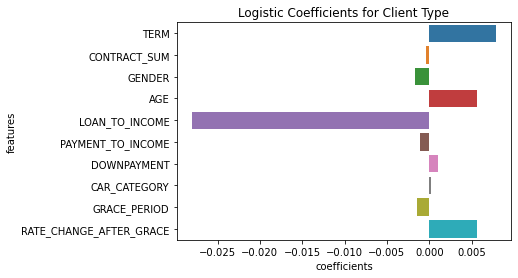

In [11]:
import seaborn as sns
visual_lr = pd.DataFrame()
visual_lr['coefficients'] = np.array(lr_est.coef_)[0]
visual_lr['features'] = clean_df.columns
sns.barplot('coefficients', 'features', data=visual_lr)
plt.title("Logistic Coefficients for Client Type")
plt.savefig("images/reliability/lr_reliability.png", dpi=300, bbox_inches='tight')

# With Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf_params = {
    'max_depth': [5, 10],
    'min_samples_leaf': [ 10, 15, 20],
    'max_samples': [0.6, None],
    'n_estimators': [400],
    'class_weight': ['balanced_subsample'],
    'n_jobs': [-1]
}

rf_clf = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample')

grid_rf = GridSearchCV(rf_clf, rf_params)
grid_rf.fit(X_train, y_train)
y_pred_rf = grid_rf.predict(X_test)

In [13]:
rf_metrics = compute_metrics(y_pred_rf, y_test)
table_builder.commit("Random Forest", rf_metrics)
print(rf_metrics)

{'0.0': {'precision': 0.21212121212121213, 'recall': 0.22702702702702704, 'f1-score': 0.21932114882506526, 'support': 185}, '1.0': {'precision': 0.8915845337376801, 'recall': 0.8828828828828829, 'f1-score': 0.8872123726895511, 'support': 1332}, 'accuracy': 0.8029004614370469, 'macro avg': {'precision': 0.5518528729294461, 'recall': 0.554954954954955, 'f1-score': 0.5532667607573082, 'support': 1517}, 'weighted avg': {'precision': 0.808723153052745, 'recall': 0.8029004614370469, 'f1-score': 0.8057622234377845, 'support': 1517}}


C:\Users\nekrald\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


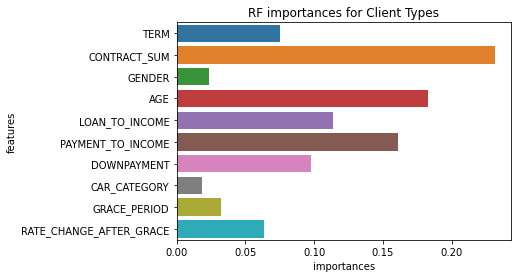

In [14]:
rf_clf = grid_rf.best_estimator_
rf_clf.fit(X_all, y_all)
importances = rf_clf.feature_importances_

visual_df = pd.DataFrame()
visual_df['importances'] = importances
visual_df['features'] = clean_df.columns
sns.barplot('importances', 'features', data=visual_df)

plt.title("RF importances for Client Types")
plt.savefig("images/reliability/rf_reliability.png", dpi=300, bbox_inches='tight')

# Performance Comparison

In [15]:
table = table_builder.make_table()
table.to_excel("tables/reliability.xlsx")
table.to_latex("tables/reliability.tex", float_format="%.2f")
table

,algorithm,accuracy,precision,recall,f1-score,rel. prec.,rel. rec.,unrel. prec.,unrel. rec.
0,Logistic Regression,0.583388,0.815860,0.583388,0.655304,0.906977,0.585586,0.159817,0.159817
1,Random Forest,0.802900,0.808723,0.802900,0.805762,0.891585,0.882883,0.212121,0.212121
